In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Preprocessing

In [3]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=20,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip = True)
    
    generator = datagen.flow_from_directory(DIR,
                                            batch_size=64,
                                            shuffle=True,
                                            target_size=(224, 224),
                                            class_mode='sparse')
    return generator

training_dir = '/content/gdrive/My Drive/Colab Notebooks/Dataset/ImageJeruk/train/'
validation_dir = '/content/gdrive/My Drive/Colab Notebooks/Dataset/ImageJeruk/validation/'

train_generator = generate_data(training_dir)
validation_generator = generate_data(validation_dir)

train_generator.class_indices

Found 200 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


{'Masak': 0, 'Mentah': 1}

## Modelling

In [4]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a sequential model
model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Fully connected layerslayers
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [5]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=20, 
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list)

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.7746 - acc: 0.4750
Epoch 1: acc improved from -inf to 0.47500, saving model to vgg16_best.h5
4/4 [==============================] - 94s 14s/step - loss: 0.7746 - acc: 0.4750 - val_loss: 0.8555 - val_acc: 0.5000
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.7922 - acc: 0.5000 
Epoch 2: acc improved from 0.47500 to 0.50000, saving model to vgg16_best.h5
4/4 [==============================] - 48s 12s/step - loss: 0.7922 - acc: 0.5000 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.6935 - acc: 0.5000 
Epoch 3: acc did not improve from 0.50000
4/4 [==============================] - 40s 13s/step - loss: 0.6935 - acc: 0.5000 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.6945 - acc: 0.4400 
Epoch 4: acc did not improve from 0.50000
4/4 [==============================] - 45s 10s/step - loss: 

## Evaluation

In [6]:
# Evaluate the model on the test data and print the accuracy
scores = model.evaluate(validation_generator)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 2s 2s/step - loss: 0.8580 - acc: 0.5000
Accuracy: 50.00%


In [7]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test data using the loaded model
y_pred = model.predict_generator(train_generator)

# Convert the predictions from probabilities to class labels
y_pred = y_pred.argmax(axis=-1)

# Get the true class labels from the test data generator
y_true = train_generator.classes

# Get the class labels for the test data generator
class_labels = list(train_generator.class_indices.keys())

# Generate and print the classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

<ipython-input-7-cf9479b58446>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(train_generator)


              precision    recall  f1-score   support

       Masak       0.50      1.00      0.67       100
      Mentah       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


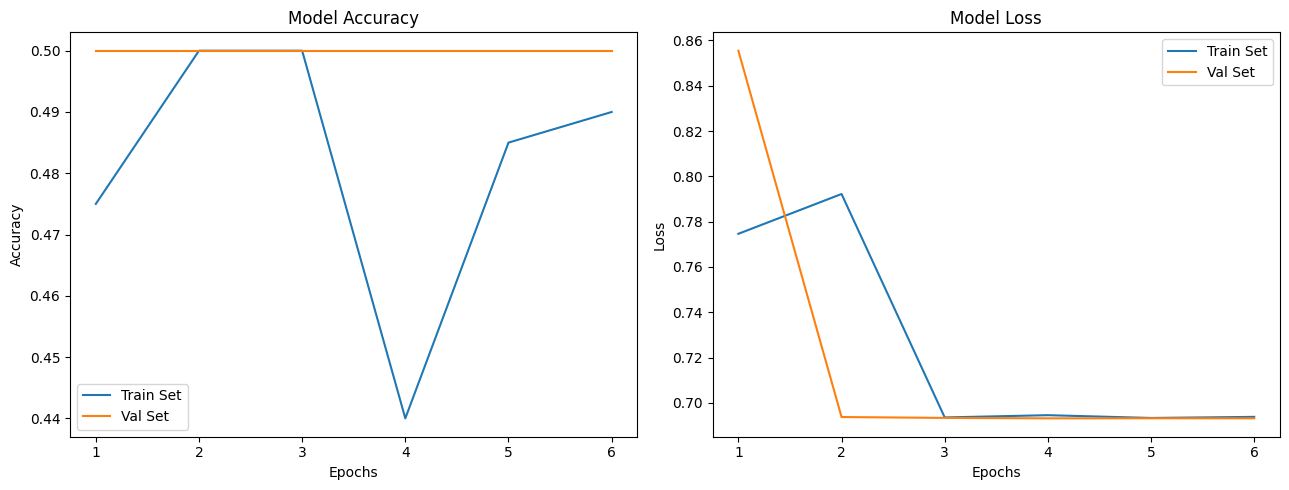

In [13]:
import matplotlib.pyplot as plt

# plot model performance
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(13,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Testing

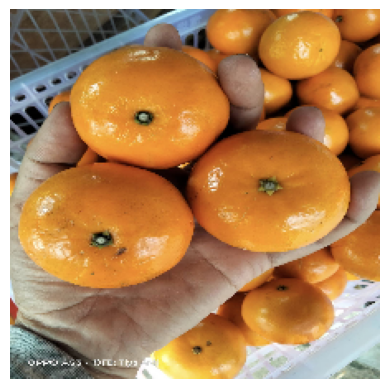

1/1 [==============================] - 0s 169ms/step
Gambar diprediksi:  Jeruk Matang


In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Model
model = load_model('vgg16_best.h5')
target_size = (224, 224)

# Load Image
image = load_img('test1.jpg', target_size=target_size)
image_array = img_to_array(image)
image_array = image_array.astype('float32')
plt.imshow(image_array/255.)
plt.axis('off')
plt.show()

image_array = np.expand_dims(image_array, axis=0)

# Prediksi label gambar menggunakan model
prediction = model.predict(image_array)

if prediction < 0.5:
    label = 'Jeruk Matang'
else:
    label = 'Jeruk Belum Matang'

print('Gambar diprediksi: ', label)